In [9]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),])
train_set = datasets.CIFAR100('./CIFAR100', download=True, train=True, transform=transform)
test_set = datasets.CIFAR100('./CIFAR100', download=True, train=False, transform=transform)
select = [3, 88]
train_set.targets = np.array(train_set.targets)
test_set.targets = np.array(test_set.targets)
train_idx = train_set.targets == -1
test_idx = test_set.targets == -1
for item in select:
    train_idx += train_set.targets == item
    test_idx += test_set.targets == item
train_set.targets = train_set.targets[train_idx]
train_set.data = train_set.data[train_idx]
test_set.targets = test_set.targets[test_idx]
test_set.data = test_set.data[test_idx]
for index, item in enumerate(select):
    train_set.targets[train_set.targets == item] = index
    test_set.targets[test_set.targets == item] = index

train_size = len(train_set.targets)
test_size = len(test_set.targets)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, drop_last=True)

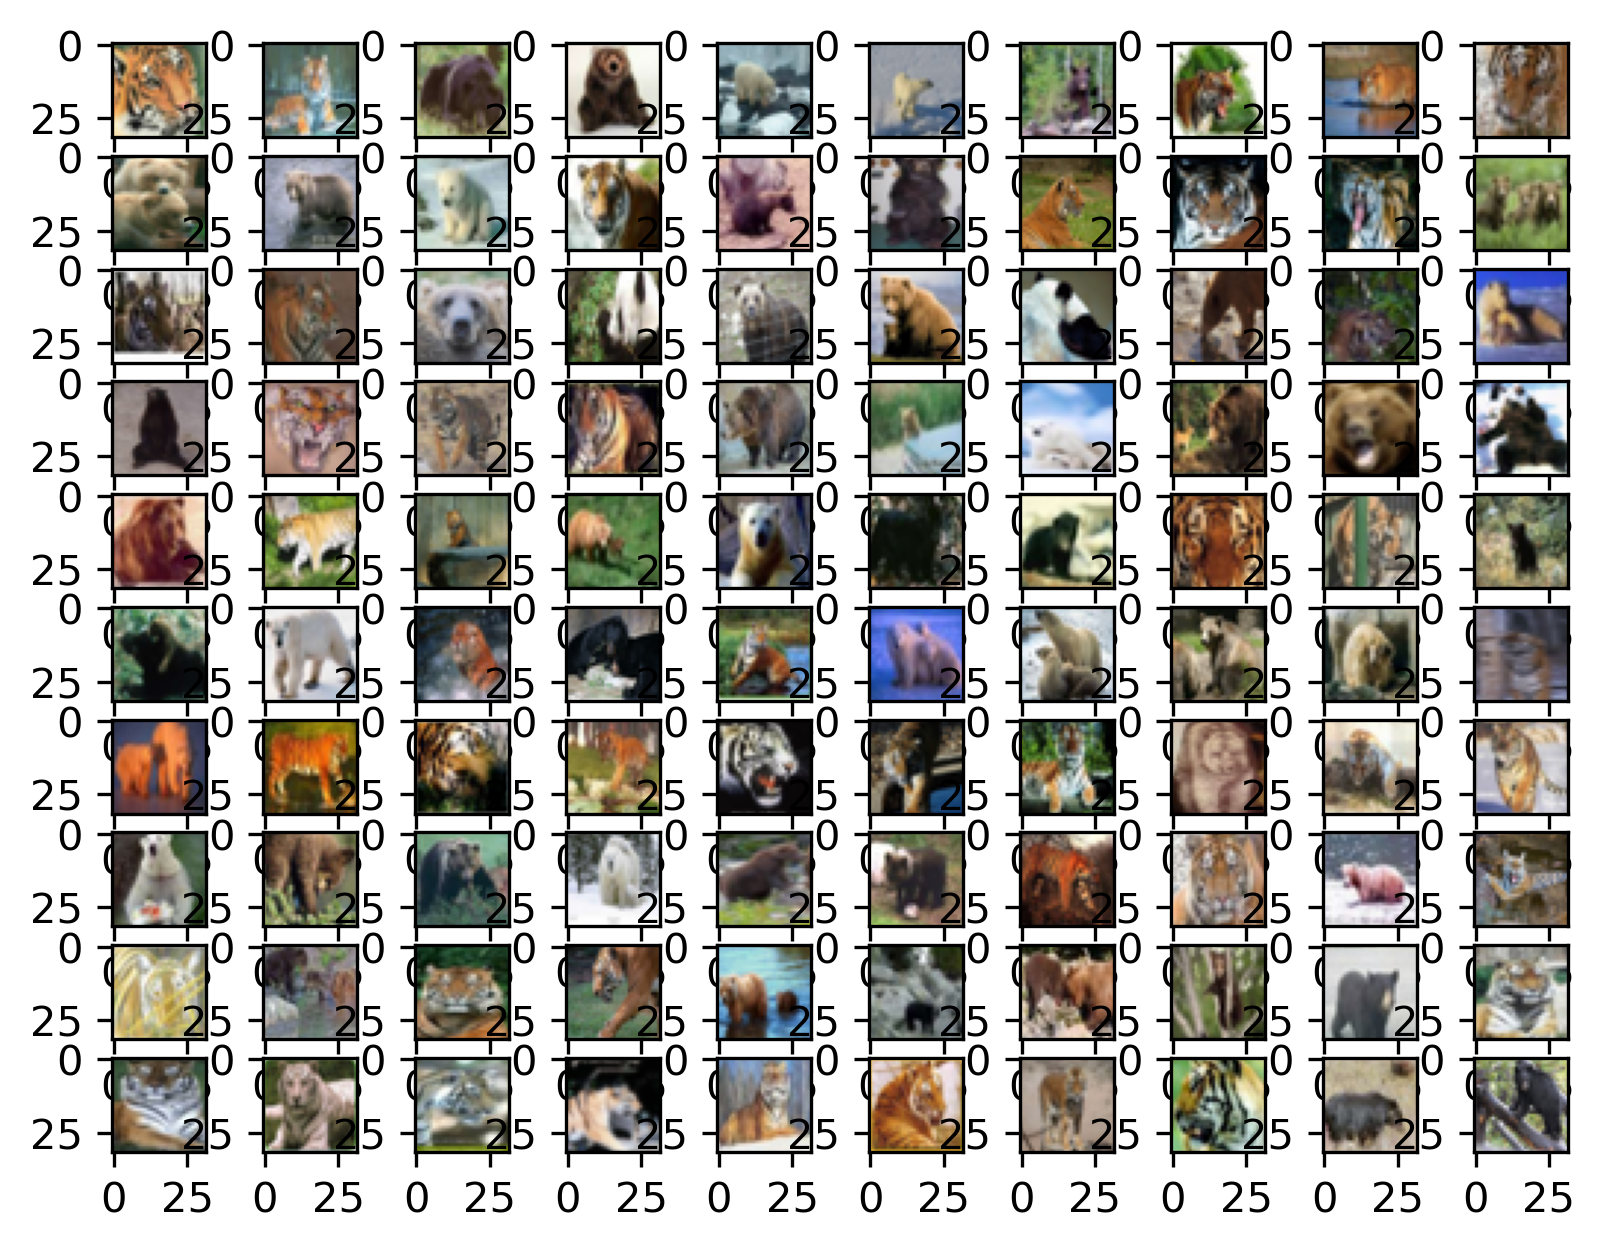

In [4]:
fig, ax = plt.subplots(10, 10, dpi=300)
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(train_set.data[i*10+j])
plt.show()

In [5]:
n_epochs = 50   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "." # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((16, 16, 4))
    
    # Loop over the coordinates of the top-left pixel of 2x2 squares
    for j in range(0, 32, 2):
        for k in range(0, 32, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            if j + 1 < 32 and k + 1 < 32:
                q_results = circuit([
                    image[0, 0, j, k],
                    image[0, 0, j, k + 1],
                    image[0, 0, j + 1, k],
                    image[0, 0, j + 1, k + 1]
                ])
            # Compute the mean of q_results and assign it to out[j // 2, k // 2, c]
            for c in range(4):
                out[j // 2, k // 2, c] = np.mean(q_results)
    return out


q_train_images = []
print("Quantum pre-processing of train images:")
for img, idx in train_loader:
    print("{}/{}        ".format(idx + 1, n_train), end="\r")
    print(img.shape)
    img = img.permute(0,2,3,1)
    img = img[:, None, :, :, :]
    print(img.shape)
    q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)

q_test_images = []
print("\nQuantum pre-processing of test images:")
for img, idx in test_loader:
    print("{}/{}        ".format(idx + 1, n_test), end="\r")
    print(img.shape)
    img = img.permute(0,2,3,1)
    img = img[:, None, :, :, :]
    print(img.shape)
    q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)


Quantum pre-processing of train images:
tensor([2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2,
        2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2,
torch.Size([64, 3, 32, 32])
torch.Size([64, 1, 32, 32, 3])


/Users/avachou/anaconda3/envs/QuantumCompetition/lib/python3.10/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


tensor([1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1,
torch.Size([64, 3, 32, 32]), 1, 1, 2, 2, 2, 2, 1, 1, 1])/50        
torch.Size([64, 1, 32, 32, 3])
tensor([2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2,
torch.Size([64, 3, 32, 32]), 2, 1, 2, 2, 2, 1, 1, 2, 2])/50        
torch.Size([64, 1, 32, 32, 3])
tensor([1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2,
        2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2,
torch.Size([64, 3, 32, 32]), 1, 1, 1, 1, 2, 1, 2, 2, 2])/50        
torch.Size([64, 1, 32, 32, 3])
tensor([2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1,
        2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1,
torch.Size([64, 3, 32, 32]), 1, 2, 2, 2, 1, 1, 1, 1, 2])/50    

In [7]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# class MyCNN(nn.Module):
#     def __init__(self):
#         super(MyCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # input channels=3, output channels=64, kernel_size=3
#         self.pool = nn.MaxPool2d(2, 2)  # max pooling, kernel_size=2, stride=2
#         self.conv2 = nn.Conv2d(64, 64, 3, padding=1)  # input channels=64, output channels=64, kernel_size=3
#         self.dropout = nn.Dropout2d(p=0.2)  # dropout with probability 0.2
#         self.fc1 = nn.Linear(64 * 8 * 8, 10)  # fully connected layer

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))  # convolution -> ReLU -> max pooling
#         x = self.pool(F.relu(self.conv2(x)))  # convolution -> ReLU -> max pooling
#         x = self.dropout(x)  # apply dropout
#         x = x.view(-1, 64 * 8 * 8)  # flatten the tensor
#         x = self.fc1(x)  # fully connected layer
#         return x

# q_model = MyCNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(q_model.parameters(), lr=0.001)

# for epoch in range(n_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         labels = labels.long()  # 將目標張量轉換為 LongTensor
#         optimizer.zero_grad()
#         outputs = q_model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         if i % 2000 == 1999:  # 每 2000 個 mini-batches 印出一次
#             print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}")
#             running_loss = 0.0

#     # 在每個 epoch 結束後，你也可以印出該 epoch 的訓練結果
#     print(f"Epoch {epoch + 1} finished. Loss: {running_loss / len(train_loader):.3f}")



In [10]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)  # 添加額外的卷積層
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # 再次添加額外的卷積層
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)  # 修改全連接層
        self.fc2 = nn.Linear(1024, 512)  # 添加額外的全連接層
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  # 使用激活函數後進行池化
        x = self.pool(F.relu(self.conv3(x)))  # 使用激活函數後進行池化
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # 使用激活函數
        x = self.fc3(x)
        return x

q_model = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(q_model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.long()
        optimizer.zero_grad()
        outputs = q_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

    print(f"Epoch {epoch + 1} finished. Loss: {running_loss / len(train_loader):.3f}")


Epoch 1 finished. Loss: 0.943
Epoch 2 finished. Loss: 0.703
Epoch 3 finished. Loss: 0.689
Epoch 4 finished. Loss: 0.645
Epoch 5 finished. Loss: 0.550
Epoch 6 finished. Loss: 0.438
Epoch 7 finished. Loss: 0.381
Epoch 8 finished. Loss: 0.336
Epoch 9 finished. Loss: 0.293
Epoch 10 finished. Loss: 0.264
Epoch 11 finished. Loss: 0.213
Epoch 12 finished. Loss: 0.219
Epoch 13 finished. Loss: 0.192
Epoch 14 finished. Loss: 0.159
Epoch 15 finished. Loss: 0.155
Epoch 16 finished. Loss: 0.160
Epoch 17 finished. Loss: 0.111
Epoch 18 finished. Loss: 0.071
Epoch 19 finished. Loss: 0.113
Epoch 20 finished. Loss: 0.097
Epoch 21 finished. Loss: 0.053
Epoch 22 finished. Loss: 0.049
Epoch 23 finished. Loss: 0.022
Epoch 24 finished. Loss: 0.009
Epoch 25 finished. Loss: 0.007
Epoch 26 finished. Loss: 0.002
Epoch 27 finished. Loss: 0.001
Epoch 28 finished. Loss: 0.001
Epoch 29 finished. Loss: 0.000
Epoch 30 finished. Loss: 0.000
Epoch 31 finished. Loss: 0.000
Epoch 32 finished. Loss: 0.000
Epoch 33 finished

In [ ]:
correct = 0
total = 0
with torch.no_grad():  # 停用梯度計算
    for data in test_loader:
        inputs, labels = data
        outputs = q_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy of the network on the test images: {accuracy:.2%}")


In [ ]:
torch.save(q_model.state_dict(), 'q_model.pth')